In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bootstrap_point632_score


#read original dataframe
df = pd.read_csv("nfl_clean.csv")


# map our y values (PASS and RUSH) to binary classifier
# 0 corresponds to RUSH; 1 corresponds to PASS
play_map = {'RUSH':0, 'PASS':1}
df['PlayType'] = df['PlayType'].map(play_map)
print(df['PlayType'].value_counts())


# one hot encode formation
one_hot = pd.get_dummies(df['Formation'])
df = df.drop('Formation', axis = 1)
df = df.join(one_hot)


# get test data as the last two weeks of NFL games, get the train and validation data as a random split among the rest
def string_int(string):
    return int(string.replace("-",""))

df2= df.sort_values(by = "GameDate").reset_index()

df2["GameDate"] = df2["GameDate"].apply(string_int)

test = df2[df2["GameDate"] > 20201224]
train = df2[df2["GameDate"] < 20201224]

actual_train, val = train_test_split(train, random_state = 1)


# get the relevant x and y columns into respective train, valid, test dataframes/series
X = ['Down', 'ToGo', 'YardLine', 'Time Left', 'NO HUDDLE', 'NO HUDDLE SHOTGUN', 'SHOTGUN', 'UNDER CENTER']
x_train = actual_train[X]
y_train = actual_train['PlayType']
x_val = val[X]
y_val = val['PlayType']
x_test = test[X]
y_test = test['PlayType']
x_full_train = train[X]
y_full_train = train['PlayType']

# x_train, x_valid, y_train, and y_valid will be used for holdout method
# x_full_train and y_full_train will be used for cross validation methods

1    20075
0    12537
Name: PlayType, dtype: int64


1     0.636656
5     0.724307
9     0.727107
13    0.722067
17    0.714226
21    0.698404
25    0.687903
29    0.679782
dtype: float64

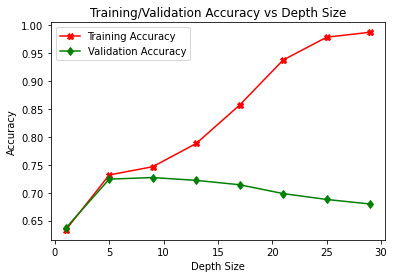

In [2]:
#random forest model

from sklearn.ensemble import RandomForestClassifier

max_depths = range(1,32,4)

depth_score_train = {}
depth_score_val = {}

for i in max_depths:
    forest = RandomForestClassifier(max_depth = i, random_state=1)
    forest.fit(x_train, y_train)
    depth_score_train[i] = forest.score(x_train,y_train)
    depth_score_val[i] = forest.score(x_val, y_val)

train_depth_series = pd.Series(depth_score_train)
val_depth_series = pd.Series(depth_score_val)


plt.plot(train_depth_series.keys(), train_depth_series, color = "red", marker = "X")
plt.plot(val_depth_series.keys(), val_depth_series, color = "green", marker = "d")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title("Training/Validation Accuracy vs Depth Size")
plt.xlabel("Depth Size")
plt.ylabel("Accuracy")

val_depth_series

In [3]:
forest = RandomForestClassifier(max_depth = 13, random_state=1)
forest.fit(x_train,y_train)
print(forest.score(x_test,y_test))

0.7288680177953535


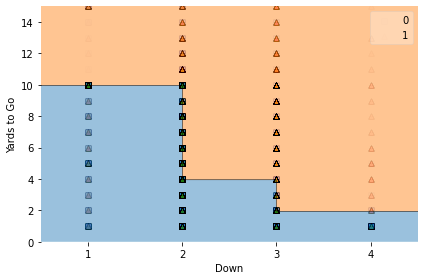

0.6518390589992532
0.6505180621674601
[1]


In [4]:
# 2D decision tree: down and togo
from sklearn.tree import DecisionTreeClassifier

dt_x = ['Down', 'ToGo']

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=6, 
                              random_state=1)
tree.fit(x_train[dt_x], y_train)

plot_decision_regions(np.array(x_train[dt_x]), np.array(y_train), tree, scatter_kwargs = {'alpha':0.005})

plt.xlabel('Down')
plt.ylabel('Yards to Go')
plt.ylim(0,15)
plt.xlim(0.5,4.5)
plt.xticks([1,2,3,4])
plt.tight_layout()
plt.show()

print(tree.score(x_train[dt_x], y_train))
print(tree.score(x_val[dt_x], y_val))
print(tree.predict(np.array([2, 4]).reshape(1, 2)))
# imagine the decision boundary is shifted down and to the left 1/2 unit

In [5]:
# higher dimension decision tree
tree2 = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=6, 
                              random_state=1)
tree2.fit(x_train, y_train)
print(tree2.score(x_train, y_train))
print(tree2.score(x_val, y_val))

#almost as good as random forest

0.7327296489917849
0.7251470176421171


0.651465646004481
0.6495379445533463


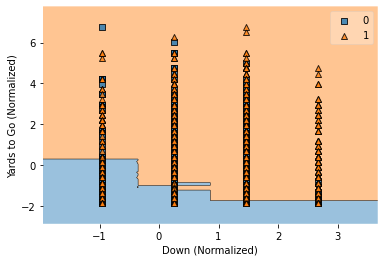

0.7285287528005975
0.7238868664239709


In [6]:
# knn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.neighbors import KNeighborsClassifier

knn_x_train_dt = scaler.fit_transform(x_train[dt_x])
knn_x_val_dt = scaler.fit_transform(x_val[dt_x])
knn_x_test_dt = scaler.fit_transform(x_test[dt_x])

knn_x_train = scaler.fit_transform(x_train)
knn_x_val = scaler.fit_transform(x_val)
knn_x_test = scaler.fit_transform(x_test)

knn = KNeighborsClassifier(n_neighbors=90)
knn.fit(knn_x_train_dt, y_train)
print(knn.score(knn_x_train_dt, y_train))
print(knn.score(knn_x_val_dt, y_val))


plt.xlabel('Down (Normalized)')
plt.ylabel('Yards to Go (Normalized)')
plot_decision_regions(np.array(knn_x_train_dt), np.array(y_train), knn)
plt.show()

knn2 = KNeighborsClassifier(n_neighbors=100)
knn2.fit(knn_x_train, y_train)
print(knn2.score(knn_x_train, y_train))
print(knn2.score(knn_x_val, y_val))

In [7]:
# adaboost

from sklearn.ensemble import AdaBoostClassifier
base_tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=3)
boost = AdaBoostClassifier(base_estimator=base_tree,
                           n_estimators=50,
                           algorithm='SAMME',
                           random_state=1,
                           learning_rate = 0.06)
boost.fit(x_train, y_train)

print(boost.score(x_train, y_train))
print(boost.score(x_val, y_val))



# Compute Out-of-bag Bootstrap -- this takes too long to run
#scores = bootstrap_point632_score(estimator=boost,
#                                  random_seed=1,
#                                  X=x_full_train,
#                                  y=y_full_train,
#                                  n_splits=100,
#                                  method='.632+')
# Compute accuracy (average over the bootstrap rounds)
#acc = np.mean(scores)
#print('Accuracy: %.2f%%' % (100*acc))

# Compute the 95% confidence interval around the accuracy estimate
#lower = np.percentile(scores, 2.5)
#upper = np.percentile(scores, 97.5)
#print('95%% Confidence interval: [%.2f, %.2f]' % (lower*100, upper*100))

0.7276418969380134
0.7233267992159059


In [8]:
# stacking
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

clf1 = RandomForestClassifier(max_depth = 9, random_state=1)
clf2 = tree2
clf3 = knn2
clf4 = boost
lr = LogisticRegression(random_state=1)

estimators = [('clf1', clf1),
              ('clf2', clf2),
              ('clf3', clf3),
              ('clf4', clf4)]

sclf = StackingClassifier(estimators=estimators, 
                          final_estimator=lr, 
                          cv=10)
sclf.fit(x_train, y_train)
print(sclf.score(x_train, y_train))
print(sclf.score(x_val, y_val))

0.7456123973114265
0.7271072528703444


In [9]:
len(x_train)

21424

In [10]:
len(x_test)

4046

In [11]:
len(x_val)

7142

In [12]:
#TODO: fit bagging model

In [13]:
#TODO: get the testing accuracy of the models
print(knn2.score(knn_x_test, y_test))

0.7291151754819575


In [14]:
print(knn.score(knn_x_test_dt, y_test))

0.6552150271873455


In [15]:
print(tree.score(x_test[dt_x], y_test))

0.6608996539792388


In [16]:
print(boost.score(x_test, y_test))

0.7308452792881859


In [17]:
print(tree2.score(x_test, y_test))

0.7338111715274345


In [18]:
print(sclf.score(x_test, y_test))

0.7340583292140386


In [19]:
#TODO: fit bagging model
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=None)


bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        oob_score=True,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

bag.fit(x_train, y_train)
    

print("OOB Accuracy: %0.5f" % bag.oob_score_)
print("Validation Accuracy: %0.5f" % bag.score(x_val, y_val))
print("Test Accuracy: %0.5f" % bag.score(x_test, y_test))

OOB Accuracy: 0.69436
Validation Accuracy: 0.68496
Test Accuracy: 0.68290


In [20]:
tree_new = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=6)

bag = BaggingClassifier(base_estimator=tree_new,
                        n_estimators=500,
                        oob_score=True,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

bag.fit(x_train, y_train)
    

print("OOB Accuracy: %0.5f" % bag.oob_score_)
print("Validation Accuracy: %0.5f" % bag.score(x_val, y_val))
print("Test Accuracy: %0.5f" % bag.score(x_test, y_test))

OOB Accuracy: 0.73077
Validation Accuracy: 0.72431
Test Accuracy: 0.73381


In [21]:
tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=6)

tree.fit(x_train, y_train)

print("Training Accuracy: %0.5f" % tree.score(x_train, y_train))
print("Test Accuracy: %0.5f" % tree.score(x_test, y_test))

Training Accuracy: 0.73273
Test Accuracy: 0.73381


In [22]:
tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=None)

tree.fit(x_train, y_train)

print("Training Accuracy: %0.5f" % tree.score(x_train, y_train))
print("Test Accuracy: %0.5f" % tree.score(x_test, y_test))

Training Accuracy: 0.98936
Test Accuracy: 0.63989


In [23]:
tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=1)

tree.fit(x_train, y_train)

print("Training Accuracy: %0.5f" % tree.score(x_train, y_train))
print("Test Accuracy: %0.5f" % tree.score(x_test, y_test))

Training Accuracy: 0.72190
Test Accuracy: 0.72590


In [24]:
tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=2)

tree.fit(x_train, y_train)

print("Training Accuracy: %0.5f" % tree.score(x_train, y_train))
print("Test Accuracy: %0.5f" % tree.score(x_test, y_test))

Training Accuracy: 0.72190
Test Accuracy: 0.72590


In [25]:
tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=3)

tree.fit(x_train, y_train)

print("Training Accuracy: %0.5f" % tree.score(x_train, y_train))
print("Test Accuracy: %0.5f" % tree.score(x_test, y_test))

Training Accuracy: 0.72190
Test Accuracy: 0.72590


In [26]:
tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=4)

tree.fit(x_train, y_train)

print("Training Accuracy: %0.5f" % tree.score(x_train, y_train))
print("Test Accuracy: %0.5f" % tree.score(x_test, y_test))

Training Accuracy: 0.72783
Test Accuracy: 0.72763


In [27]:
tree6 = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=5)

tree.fit(x_train, y_train)

print("Training Accuracy: %0.5f" % tree.score(x_train, y_train))
print("Test Accuracy: %0.5f" % tree.score(x_test, y_test))

Training Accuracy: 0.72783
Test Accuracy: 0.72763


In [28]:
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        oob_score=True,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

bag.fit(x_train, y_train)
print(bag.score(x_train, y_train))
print(bag.score(x_val, y_val))

0.7270351008215086
0.7229067488098572


In [29]:
bag2 = BaggingClassifier(base_estimator=tree6,
                        n_estimators=500,
                        oob_score=True,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

bag2.fit(x_train, y_train)
print(bag2.score(x_train, y_train))
print(bag2.score(x_val, y_val))

0.73212285287528
0.7248669840380846
